In [47]:
#instalando librerias

!pip install pyspark
!pip install nltk
!pip install matplotlib

In [48]:
#imports
from pyspark.sql import SparkSession
import json
import nltk
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt

In [3]:
#create spar session object
spark = SparkSession.builder.appName('data_processing').getOrCreate()

In [4]:
# Load csv Dataset 
df = spark.read.csv('sources/sample_metadata.csv',inferSchema=True,header=True)

In [9]:
# revisando columnas e info general del csv
print(f'Columnas del csv:')
print(*df.columns, sep = ', ')
print(f'numero de Columnas del csv {len(df.columns)}')
print(f'Numero de registros del csv {df.count()}')
print('Esquema del csv: ')
df.printSchema()

Columnas del csv:
cord_uid, sha, source_x, title, doi, pmcid, pubmed_id, license, abstract, publish_time, authors, journal, mag_id, who_covidence_id, arxiv_id, pdf_json_files, pmc_json_files, url
numero de Columnas del csv 18
Numero de registros del csv 4
Esquema del csv: 
root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: integer (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)



In [49]:
#se crea una lista con las urls de los json de la data de los pdf
cols = df.select("pdf_json_files").rdd.flatMap(list).collect()
all_tokens = []
for json_url in cols:
    
    #se abre el archivo json
    with open(str(json_url)) as f:
        
        #se crea un objeto json con el contendio del arcivo que se acaba de abrir
        json_object = json.load(f) 
    
    #se recorre los items 'body_text' del obejto json
    for body_text_item in json_object['body_text']:
        
        #se el campo text del item 'body_text', se pasa todo a mayusculas, se tokeniza con nltk.worl_tokeniza y se agrega a la lista 'all_tokens'
        all_tokens.extend(nltk.word_tokenize(str(body_text_item['text']).lower()))
        
print(all_tokens)
print(f'Tamaño inicial del BoW: {len(all_tokens)}')

['the', 'genetic', 'information', 'of', 'rna', 'viruses', 'is', 'organized', 'very', 'ef®ciently', '.', 'practically', 'every', 'nucleotide', 'of', 'their', 'genome', 'is', 'utilized', ',', 'either', 'as', 'protein-coding', 'sequence', 'or', 'as', 'cis-acting', 'signals', 'for', 'translation', ',', 'rna', 'synthesis', 'or', 'rna', 'encapsidation', '.', 'as', 'part', 'of', 'their', 'genome', 'expression', 'strategy', ',', 'several', 'groups', 'of', 'positive-strand', 'rna', '(', '+rna', ')', 'viruses', 'produce', 'subgenomic', '(', 'sg', ')', 'mrnas', '(', 'reviewed', 'by', 'miller', 'and', 'koev', ',', '2000', ')', '.', 'the', 'replication', 'of', 'their', 'genomic', 'rna', ',', 'which', 'is', 'also', 'the', 'mrna', 'for', 'the', 'viral', 'replicase', ',', 'is', 'supplemented', 'with', 'the', 'generation', 'of', 'sg', 'transcripts', 'to', 'express', 'structural', 'and', 'auxiliary', 'proteins', ',', 'which', 'are', 'encoded', 'downstream', 'of', 'the', 'replicase', 'gene', 'in', 'the',

Column<b'pdf_json_files'>
Column<b'pdf_json_files[pdf_json_files]'>


In [50]:
#se elimnana los caracteres especiales
all_tokens = [w for w in all_tokens if w.isalpha()]
print(f'Tamaño del BoW despues de remover caracteres especiales: {len(all_tokens)}')

#e eliminan los tokens que contienen caracteres no ascii, aca es importante notar que no elimina propiamente el token, sino que lo reemplaza por un token vacio, por eso esto se hace antes de remover los tokens de longitud 1
all_tokens = [w.encode('ascii', 'ignore').decode('ascii') for w in all_tokens]
print(f'Tamaño del BoW despues de limpiar caracteres no ascii: {len(all_tokens)}')

#removing tokens that have one or less characteres
all_tokens = [w for w in all_tokens if len(w)>1]
print(f'Tamaño del BoW despues de remover caracteres de longitud 1 o menor: {len(all_tokens)}')
print(all_tokens)

Tamaño del BoW despues de remover caracteres especiales: 20942
Tamaño del BoW despues de limpiar caracteres no ascii: 20942
Tamaño del BoW despues de remover caracteres de longitud 1 o menor: 19954
['the', 'genetic', 'information', 'of', 'rna', 'viruses', 'is', 'organized', 'very', 'practically', 'every', 'nucleotide', 'of', 'their', 'genome', 'is', 'utilized', 'either', 'as', 'sequence', 'or', 'as', 'signals', 'for', 'translation', 'rna', 'synthesis', 'or', 'rna', 'encapsidation', 'as', 'part', 'of', 'their', 'genome', 'expression', 'strategy', 'several', 'groups', 'of', 'rna', 'viruses', 'produce', 'subgenomic', 'sg', 'mrnas', 'reviewed', 'by', 'miller', 'and', 'koev', 'the', 'replication', 'of', 'their', 'genomic', 'rna', 'which', 'is', 'also', 'the', 'mrna', 'for', 'the', 'viral', 'replicase', 'is', 'supplemented', 'with', 'the', 'generation', 'of', 'sg', 'transcripts', 'to', 'express', 'structural', 'and', 'auxiliary', 'proteins', 'which', 'are', 'encoded', 'downstream', 'of', 'th

In [51]:
# carga del diccionarion de stopword en ingles
stop_words_nltk = set(stopwords.words('english'))

#eliminar stop wrods
all_tokens = [w for w in all_tokens if w not in stop_words_nltk]
print(f'Tamaño del BoW despues de remover stop words: {len(all_tokens)}')
print(all_tokens)


Tamaño del BoW despues de remover stop words: 11763
['genetic', 'information', 'rna', 'viruses', 'organized', 'practically', 'every', 'nucleotide', 'genome', 'utilized', 'either', 'sequence', 'signals', 'translation', 'rna', 'synthesis', 'rna', 'encapsidation', 'part', 'genome', 'expression', 'strategy', 'several', 'groups', 'rna', 'viruses', 'produce', 'subgenomic', 'sg', 'mrnas', 'reviewed', 'miller', 'koev', 'replication', 'genomic', 'rna', 'also', 'mrna', 'viral', 'replicase', 'supplemented', 'generation', 'sg', 'transcripts', 'express', 'structural', 'auxiliary', 'proteins', 'encoded', 'downstream', 'replicase', 'gene', 'genome', 'sg', 'mrnas', 'viruses', 'always', 'genomic', 'rna', 'different', 'mechanisms', 'used', 'synthesis', 'viruses', 'brome', 'mosaic', 'virus', 'initiate', 'sg', 'mrna', 'synthesis', 'internally', 'minus', 'strand', 'rna', 'template', 'miller', 'et', 'others', 'red', 'clover', 'necrotic', 'mosaic', 'virus', 'rcnmv', 'may', 'rely', 'premature', 'termination',

['genet', 'inform', 'rna', 'vir', 'org', 'pract', 'every', 'nucleotid', 'genom', 'util', 'ei', 'sequ', 'sign', 'transl', 'rna', 'synth', 'rna', 'encapsid', 'part', 'genom', 'express', 'strategy', 'sev', 'group', 'rna', 'vir', 'produc', 'subgenom', 'sg', 'mrnas', 'review', 'mil', 'koev', 'reply', 'genom', 'rna', 'also', 'mrna', 'vir', 'replica', 'suppl', 'gen', 'sg', 'transcrib', 'express', 'structural', 'auxy', 'protein', 'encod', 'downstream', 'replica', 'gen', 'genom', 'sg', 'mrnas', 'vir', 'alway', 'genom', 'rna', 'diff', 'mech', 'us', 'synth', 'vir', 'brom', 'mos', 'vir', 'in', 'sg', 'mrna', 'synth', 'intern', 'min', 'strand', 'rna', 'templ', 'mil', 'et', 'oth', 'red', 'clov', 'necrot', 'mos', 'vir', 'rcnmv', 'may', 'rely', 'prem', 'termin', 'min', 'strand', 'synth', 'genom', 'rna', 'templ', 'follow', 'synth', 'sg', 'plu', 'strands', 'trunt', 'min', 'strand', 'templ', 'sit', 'et', 'memb', 'ord', 'nidovir', 'includ', 'coronavir', 'arterivir', 'evolv', 'third', 'un', 'mech', 'employ'

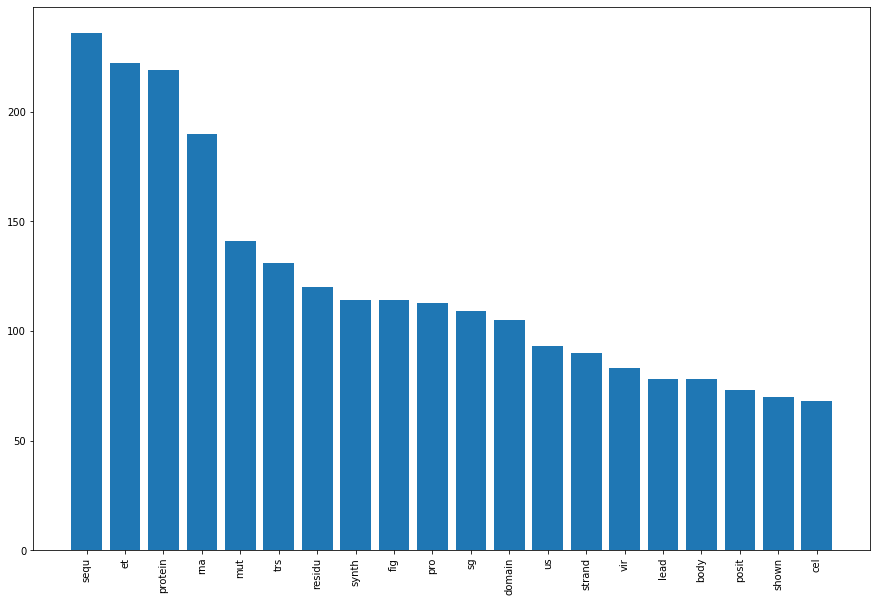

In [53]:
# steamming
from nltk.stem import LancasterStemmer

lancaster = LancasterStemmer()
all_tokens = [lancaster.stem(w) for w in all_tokens]
print(all_tokens)

fdist_steamming = nltk.FreqDist(all_tokens)
topwords_steamming = fdist_steamming.most_common(20)
print(f'Tamaño del BoW despues de steamming con landcaster: {len(fdist_steamming)}')

#grafico de frecuencia
x,y = zip(*topwords_steamming)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

['genet', 'inform', 'rna', 'vir', 'org', 'pract', 'every', 'nucleotid', 'genom', 'util', 'ei', 'sequ', 'sign', 'transl', 'rna', 'synth', 'rna', 'encapsid', 'part', 'genom', 'express', 'strategy', 'sev', 'group', 'rna', 'vir', 'produc', 'subgenom', 'sg', 'mrna', 'review', 'mil', 'koev', 'reply', 'genom', 'rna', 'also', 'mrna', 'vir', 'replica', 'suppl', 'gen', 'sg', 'transcrib', 'express', 'structural', 'auxy', 'protein', 'encod', 'downstream', 'replica', 'gen', 'genom', 'sg', 'mrna', 'vir', 'alway', 'genom', 'rna', 'diff', 'mech', 'u', 'synth', 'vir', 'brom', 'mo', 'vir', 'in', 'sg', 'mrna', 'synth', 'intern', 'min', 'strand', 'rna', 'templ', 'mil', 'et', 'oth', 'red', 'clov', 'necrot', 'mo', 'vir', 'rcnmv', 'may', 'rely', 'prem', 'termin', 'min', 'strand', 'synth', 'genom', 'rna', 'templ', 'follow', 'synth', 'sg', 'plu', 'strand', 'trunt', 'min', 'strand', 'templ', 'sit', 'et', 'memb', 'ord', 'nidovir', 'includ', 'coronavir', 'arterivir', 'evolv', 'third', 'un', 'mech', 'employ', 'dis

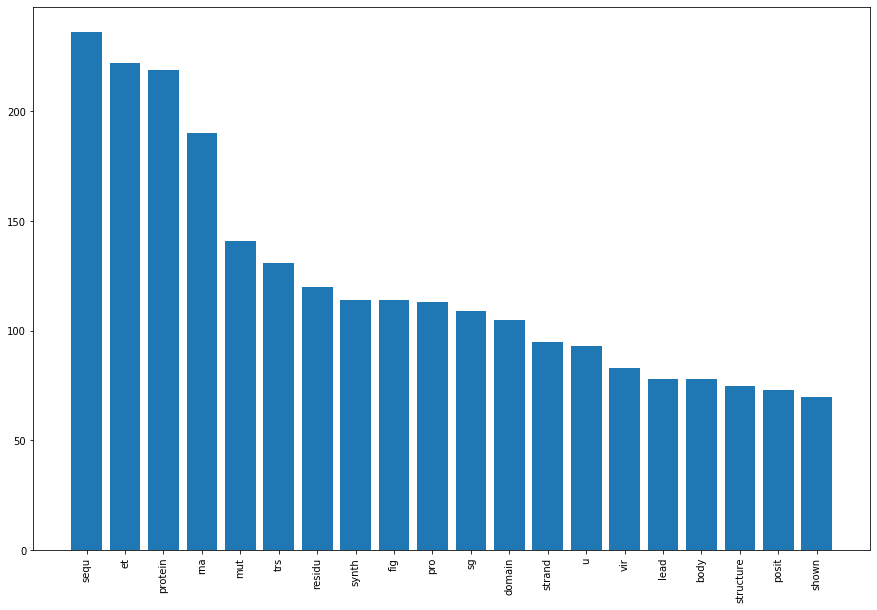

In [54]:
# Lemmatization con NLTK

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
all_tokens = [wordnet_lemmatizer.lemmatize(w) for w in all_tokens ]
print(all_tokens)

fdist_lemmatizer = nltk.FreqDist(all_tokens)
topwords_lemmatizer = fdist_lemmatizer.most_common(20)
print(f'Tamaño del BoW despues de lematizacion: {len(fdist_lemmatizer)}')
x,y = zip(*topwords_lemmatizer)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()